In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

# Define the file path
file_path = '/scratch/harvard/abaraban/df_merged.csv'

# Read the DataFrame from the CSV file
dtype_spec = {
    'crsp_obj_cd': 'string',
    'si_obj_cd': 'string',
    'wbrger_obj_cd': 'string',
    'policy': 'string',
    'lipper_asset_cd': 'string',
    'lipper_class': 'string',
    'lipper_obj_cd': 'string'
}
df_merged = pd.read_csv(file_path, dtype=dtype_spec)

# Exclude rows where 'crsp_obj_cd' starts with 'I' or 'O'
excludes_i_o = ~df_merged['crsp_obj_cd'].str.startswith(('OM', 'OC', 'I'), na=False)

# Create a new DataFrame excluding the specified 'crsp_obj_cd' codes
df_merged = df_merged[excludes_i_o]
print(df_merged.shape)

# List of substrings to check for
# Appel et al 2016
substrings = [
    'Index', 'Idx', 'Indx', 'Ind', 'Russell', 'S & P', 'S and P', 'S&P', 'SandP', 'SP',
    'DOW', 'Dow', 'DJ', 'MSCI', 'Bloomberg', 'KBW', 'NASDAQ', 'NYSE', 'STOXX',
    'FTSE', 'Wilshire', 'Morningstar', '100', '400', '500', '600', '900', '1000',
    '1500', '2000', '5000'
]
print(df_merged.shape)
# Create the 'index' column
df_merged['index'] = df_merged['fund_name'].str.contains('|'.join(substrings), case=False).astype(int)


# df_merged = df_merged[~((df_merged['index_fund_flag'] == 'D') | (df_merged['index'] == 1))]

conditions_active = (
    (df_merged['index_fund_flag'].isin(['B', 'E'])) &
    (df_merged['index'] == 0)
)

conditions_passive = (
    (df_merged['index_fund_flag'] == 'D') |
    (df_merged['index'] == 1)
)

# Initialize fund type to 'Other', then set to 'Active' or 'Passive' based on conditions
df_merged['fund_type'] = 'Other'
df_merged.loc[conditions_active, 'fund_type'] = 'Active'
df_merged.loc[conditions_passive, 'fund_type'] = 'Passive'

# Split the DataFrame into active, passive, and other
df_merged = df_merged[df_merged['fund_type'] == 'Active']
passive_funds = df_merged[df_merged['fund_type'] == 'Passive']

print("\nPassive Funds:")
print(passive_funds.shape)

# There are no other Funds

(4133743, 64)
(4133743, 64)

Passive Funds:
(0, 66)


/tmp/23357343.1.jupyterhub.q/ipykernel_3375150/3360181185.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  yearly_value_added_list = df_merged.groupby('crsp_fundno').apply(compute_yearly_value_added).reset_index(drop=True)
/tmp/23357343.1.jupyterhub.q/ipykernel_3375150/3360181185.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_value_added_list = df_merged.groupby('crsp_fundno').apply(compute_yearly_value_added).reset_index(drop=True)


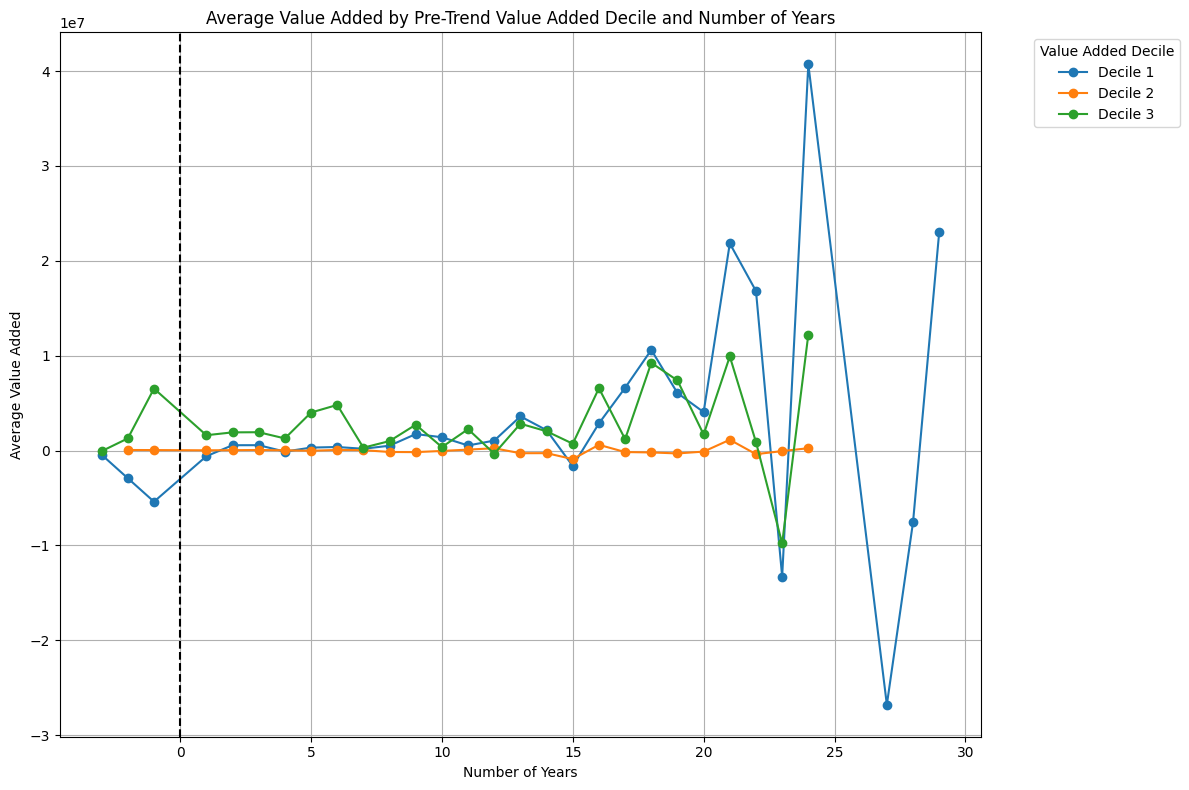

In [8]:
# Ensure DataFrame is sorted by crsp_fundno and caldt
df_merged.sort_values(by=['crsp_fundno', 'caldt'], inplace=True)

# Compute average value added for each year in the second half of observations and include a year of previous performance
def compute_yearly_value_added(group):
    group['caldt'] = pd.to_datetime(group['caldt'])
    n = len(group)
    half_n = n // 2
    if half_n > 1:
        # Split into pre-trend and second half periods
        second_half = group.iloc[half_n:].copy()
        pretrend_period = group.iloc[max(0, half_n - 2):half_n].copy()  # Include the previous 12 months
        
        # Mark pretrend period with negative year numbers
        if len(pretrend_period) > 0:
            pretrend_period['year_number'] = pretrend_period['caldt'].dt.year - pretrend_period['caldt'].dt.year.max() - 1
        
        # Mark second half period with positive year numbers
        second_half['year_number'] = second_half['caldt'].dt.year - second_half['caldt'].dt.year.min() + 1
        
        # Combine both periods
        combined = pd.concat([pretrend_period, second_half], ignore_index=True)
        
        return combined[['crsp_fundno', 'year_number', 'vanguard_VA']]
    else:
        return pd.DataFrame(columns=['crsp_fundno', 'year_number', 'vanguard_VA'])

# Apply the function to each group
yearly_value_added_list = df_merged.groupby('crsp_fundno').apply(compute_yearly_value_added).reset_index(drop=True)

# Filter only the pre-trend (negative year numbers) period
pretrend_value_added = yearly_value_added_list[yearly_value_added_list['year_number'] < 1]

# Compute the average value added during the pre-trend period for each fund
avg_pretrend_value_added = pretrend_value_added.groupby('crsp_fundno')['vanguard_VA'].mean().reset_index(name='avg_pretrend_value_added')

# Merge with the yearly value added list to get the deciles
yearly_value_added_list = yearly_value_added_list.merge(avg_pretrend_value_added, on='crsp_fundno', how='left')

# Drop rows where avg_pretrend_value_added is NaN
yearly_value_added_list = yearly_value_added_list.dropna(subset=['avg_pretrend_value_added'])

# Create deciles based on the average pre-trend value added
yearly_value_added_list['value_added_decile'] = pd.qcut(yearly_value_added_list['avg_pretrend_value_added'], 3, labels=False)

# Group by year_number and value_added_decile to compute the mean value added
decile_yearly_avg_value_added = yearly_value_added_list.groupby(['year_number', 'value_added_decile'])['vanguard_VA'].mean().unstack()

# Plot results with number of years (including pretrend) on the x-axis
plt.figure(figsize=(12, 8))
for decile in decile_yearly_avg_value_added.columns:
    plt.plot(decile_yearly_avg_value_added.index, decile_yearly_avg_value_added[decile], marker='o', label=f'Decile {decile + 1}')

plt.title('Average Value Added by Pre-Trend Value Added Decile and Number of Years')
plt.xlabel('Number of Years')
plt.ylabel('Average Value Added')
plt.axvline(x=0, color='black', linestyle='--')  # Add a vertical line to indicate the split point
plt.legend(title='Value Added Decile', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
df_merged.sort_values(by='vanguard_VA', ascending=False).head(50)

,crsp_fundno,vanguard_VA,caldt
4051383,93941,1.056520e+11,2005-09-30
4051491,93941,5.660554e+10,2014-09-30
4051451,93941,4.273877e+10,2011-05-31
4051438,93941,4.196924e+10,2010-04-30
4051472,93941,3.701207e+10,2013-02-28
4051481,93941,2.316412e+10,2013-11-29
4051432,93941,1.331873e+10,2009-10-30
1202951,16054,1.320138e+10,1985-01-31
4051400,93941,1.291307e+10,2007-02-28
4051373,93941,9.495327e+09,2004-10-29


In [9]:
yearly_value_added_list

,crsp_fundno,year_number,vanguard_VA,avg_pretrend_value_added,value_added_decile
7,2745,-1,-5.892472e+05,-336555.312415,0
8,2745,-1,-8.386338e+04,-336555.312415,0
9,2745,1,-4.527615e+05,-336555.312415,0
10,2745,1,1.042818e+06,-336555.312415,0
11,2745,2,9.193765e+03,-336555.312415,0
...,...,...,...,...,...
599230,100924,2,2.042823e+04,-53954.673213,1
599231,100924,2,-2.549471e+04,-53954.673213,1
599232,100924,2,6.652321e+04,-53954.673213,1
599233,100924,2,3.437892e+05,-53954.673213,1


In [10]:
avg_pretrend_value_added

,crsp_fundno,avg_pretrend_value_added
0,2739,NaN
1,2745,-3.365553e+05
2,2746,1.602959e+06
3,2747,2.108091e+06
4,2748,8.018233e+06
...,...,...
11478,101617,NaN
11479,101618,NaN
11480,101619,NaN
11481,101627,NaN


/tmp/23357343.1.jupyterhub.q/ipykernel_3375150/3275132426.py:7: DtypeWarning: Columns (13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_merged = pd.read_csv(file_path, parse_dates=['caldt'])
/tmp/23357343.1.jupyterhub.q/ipykernel_3375150/3275132426.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  yearly_value_added_list = df_merged.groupby('crsp_fundno').apply(compute_yearly_value_added).reset_index(drop=True)
/tmp/23357343.1.jupyterhub.q/ipykernel_3375150/3275132426.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=F

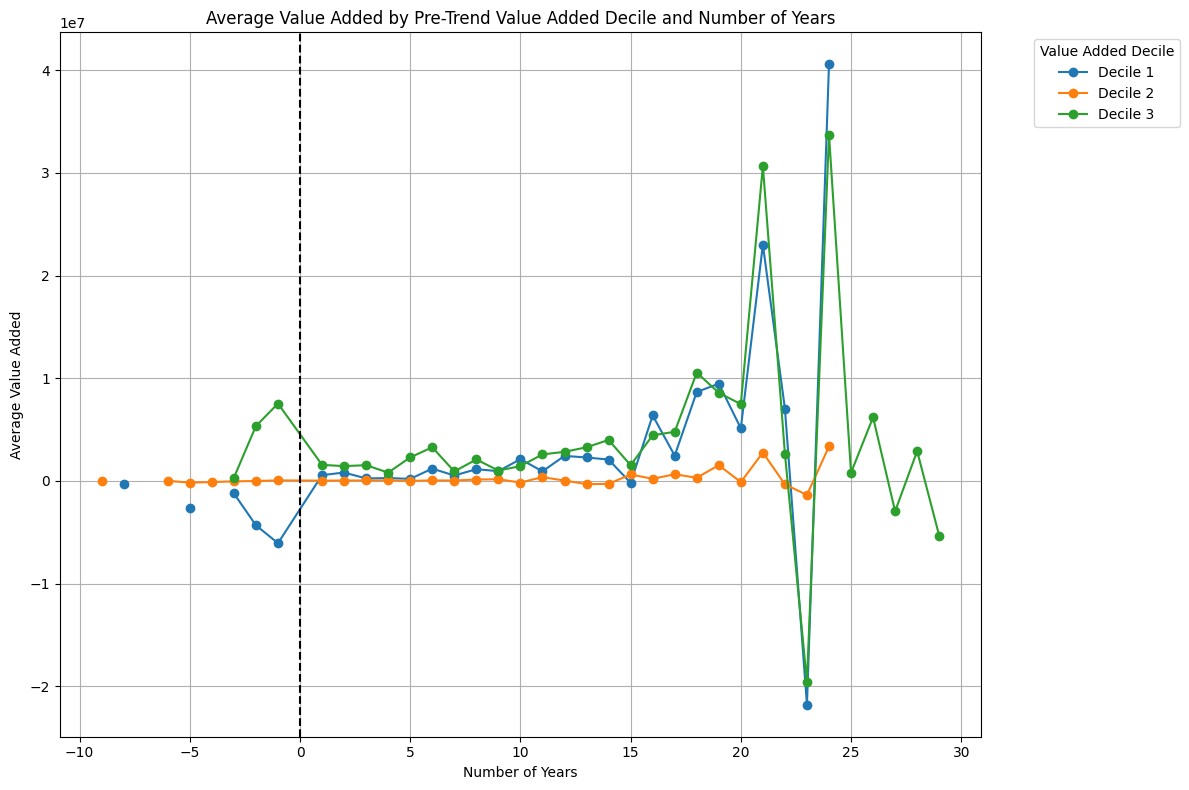

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your CSV file
file_path = '/scratch/harvard/abaraban/df_merged.csv'
df_merged = pd.read_csv(file_path, parse_dates=['caldt'])

# Ensure DataFrame is sorted by crsp_fundno and caldt
df_merged.sort_values(by=['crsp_fundno', 'caldt'], inplace=True)

# Compute average value added for each year in the second half of observations and include a year of previous performance
def compute_yearly_value_added(group):
    group['caldt'] = pd.to_datetime(group['caldt'])
    n = len(group)
    half_n = n // 2
    if half_n > 1:
        # Split into pre-trend and second half periods
        second_half = group.iloc[half_n:].copy()
        pretrend_period = group.iloc[max(0, half_n - 2):half_n].copy()  # Include the previous 12 months
        
        # Mark pretrend period with negative year numbers
        if len(pretrend_period) > 0:
            pretrend_period['year_number'] = pretrend_period['caldt'].dt.year - pretrend_period['caldt'].dt.year.max() - 1
        
        # Mark second half period with positive year numbers
        second_half['year_number'] = second_half['caldt'].dt.year - second_half['caldt'].dt.year.min() + 1
        
        # Combine both periods
        combined = pd.concat([pretrend_period, second_half], ignore_index=True)
        
        return combined[['crsp_fundno', 'year_number', 'vanguard_VA', 'fund_name']]
    else:
        return pd.DataFrame(columns=['crsp_fundno', 'year_number', 'vanguard_VA', 'fund_name'])

# Apply the function to each group
yearly_value_added_list = df_merged.groupby('crsp_fundno').apply(compute_yearly_value_added).reset_index(drop=True)

# Filter only the pre-trend (negative year numbers) period
pretrend_value_added = yearly_value_added_list[yearly_value_added_list['year_number'] < 1]

# Compute the average value added during the pre-trend period for each fund
avg_pretrend_value_added = pretrend_value_added.groupby('crsp_fundno')['vanguard_VA'].mean().reset_index(name='avg_pretrend_value_added')

# Merge with the yearly value added list to get the deciles
yearly_value_added_list = yearly_value_added_list.merge(avg_pretrend_value_added, on='crsp_fundno', how='left')

# Drop rows where avg_pretrend_value_added is NaN
yearly_value_added_list = yearly_value_added_list.dropna(subset=['avg_pretrend_value_added'])

# Create deciles based on the average pre-trend value added
yearly_value_added_list['value_added_decile'] = pd.qcut(yearly_value_added_list['avg_pretrend_value_added'], 3, labels=False)

# Store fund names in each decile
fund_names_by_decile = yearly_value_added_list[['fund_name', 'value_added_decile']].drop_duplicates().groupby('value_added_decile')['fund_name'].apply(list)

# Group by year_number and value_added_decile to compute the mean value added
decile_yearly_avg_value_added = yearly_value_added_list.groupby(['year_number', 'value_added_decile'])['vanguard_VA'].mean().unstack()

# Plot results with number of years (including pretrend) on the x-axis
plt.figure(figsize=(12, 8))
for decile in decile_yearly_avg_value_added.columns:
    plt.plot(decile_yearly_avg_value_added.index, decile_yearly_avg_value_added[decile], marker='o', label=f'Decile {decile + 1}')

plt.title('Average Value Added by Pre-Trend Value Added Decile and Number of Years')
plt.xlabel('Number of Years')
plt.ylabel('Average Value Added')
plt.axvline(x=0, color='black', linestyle='--')  # Add a vertical line to indicate the split point
plt.legend(title='Value Added Decile', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Display fund names in each decile
for decile, fund_names in fund_names_by_decile.items():
    print(f"Decile {decile + 1}:")
    for fund_name in fund_names:
        print(f" - {fund_name}")
    print("\n")

In [16]:
for decile, fund_names in fund_names_by_decile.items():
    x = fund_names
    x

In [15]:
fund_names_by_decile.items())

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__next__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

In [17]:
x

['Alliance Strategic Balanced Fund/B',
 "AMERICAN CAPITAL GOVERNMENT TGT SRS-PORT '97",
 'Advantage Income Fund',
 'Northstar Advantage Fds:Income Fund/T',
 'Northstar Balance Sheet Opportunities Fund/T',
 'Pilgrim Balance Sheet Opportunities Fund, Inc.; Class T Shares',
 'Rea-Graham Balanced Fund',
 'Rea-Graham Funds:Balanced Fund',
 'American Diversified:Global Value Fund',
 'Alliance Global Enviroment Fund/A',
 'Alliance Global Environment Fund, Inc.; Class A Shares',
 'AARP Growth & Income Fund',
 'AARP Growth Tr:Growth and Income Fund',
 'AARP Growth Trust: AARP Growth and Income Fund',
 'Alliance Income Builder Fund/C',
 'Special Portfolio, Inc.--Stock',
 'Fortis Special Portfolio--Stock',
 'Special Portfolios:Stock Portfolio',
 'AmSouth Mutual Fds:Regional Equity Fd/Classic',
 'AmSouth Funds: AmSouth Regional Equity Fund; Class A Shares',
 'American Perform Equity Inv Fd:Aggr Growth Fd',
 'Olympus Stock Fund',
 'OLYMPUS STOCK FUND',
 'ARCH Fund:Growth & Income Equity/Inv A',
 'M